# Background

**Example 4.2**: Jack’s Car Rental Jack manages two locations for a nationwide car rental company.
Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he
rents it out and is credited \\$10 by the national company. If he is out of cars at that location, then the
business is lost. Cars become available for renting the day after they are returned. To help ensure that
cars are available where they are needed, Jack can move them between the two locations overnight, at
a cost of \\$2 per car moved. We assume that the number of cars requested and returned at each location
$n$
are Poisson random variables, meaning that the probability that the number is $n$ is $\frac{\lambda^n}{n!} e^{-\lambda}$ , where $\lambda$ is
the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and
3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20
cars at each location (any additional cars are returned to the nationwide company, and thus disappear
from the problem) and a maximum of five cars can be moved from one location to the other in one
night. We take the discount rate to be $\gamma = 0.9$ and formulate this as a continuing finite MDP, where
the time steps are days, the state is the number of cars at each location at the end of the day, and
the actions are the net numbers of cars moved between the two locations overnight. Figure 4.2 shows the sequence of policies found by policy iteration starting from the policy that never moves any cars.

![](jacks_car_rental.png)

**Figure 4.2**: The sequence of policies found by policy iteration on Jack’s car rental problem, and the final
state-value function. The first five diagrams show, for each number of cars at each location at the end of the
day, the number of cars to be moved from the first location to the second (negative numbers indicate transfers
from the second location to the first). Each successive policy is a strict improvement over the previous policy,
and the last policy is optimal.



# Code

![](policy_iteration.png)

In [121]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
from itertools import product
from functools import reduce
from functools import partial
from functools import lru_cache
import pickle
import pandas as pd
import numpy as np
from scipy.stats import poisson


LAMBDA_1_REQUEST = 3
LAMBDA_2_REQUEST = 4
LAMBDA_1_RETURN = 3
LAMBDA_2_RETURN = 2

MAX_CARS_AT_LOC = 20
MAX_MOVES_OVER_NIGHT = 5

def states():
    """Generates all possible states.
    """
    for location_1, location_2 in product(range(21), range(21)):
        yield (location_1, location_2)

STATE_SPACE_CARDINALITY = len(list(states()))

THETA = 1e-09
GAMMA = 0.9

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
l = [1,2,3]
max(zip(l, range(len(l))))[1]

2

In [180]:
def policy_iteration():
    """Do the three steps in policy iteration.
    """

    # 1. Initialize.
    state_value = {s: 0 for s in STATES}
    policy = {s: 0 for s in STATES}
    
    # 2. Policy Evaluation.
    state_value = policy_evaluation(policy, state_value)
    
    # 3. Policy Improvement.
    policy_improvement_iteration = 1
    while True:
        
        old_policy = policy.copy()
        policy_stable = True
        
        for idx, state in enumerate(states()):

            policy[state] = best_action(state, state_value)
            
            if policy[state] != old_policy[state]:
                policy_stable = False
            
        if policy_stable:
            break
        
        state_value = policy_evaluation(policy, state_value, policy_improvement_iteration)

        policy_improvement_iteration += 1

    return policy, state_value


def best_action(state, state_value):
    state_actions = np.array(list(actions(state)))
    return state_actions[np.argmax([
        action_value(state, action, state_value) for action in actions(state)
    ])]


def policy_evaluation(policy, state_value, policy_improvement_iteration=0):
    """Evaluate a given policy.
    """
    policy_evaluation_iteration = 0
    
    while True:
        
        old_state_value = state_value.copy()

        delta = 0
        
        for state_progress, state in enumerate(states()):

            action = policy[state]
            
            state_value[state] = action_value(state, action, state_value)
            
            delta = max(delta, abs(old_state_value[state] - state_value[state]))
            
            
            track_progress(policy_improvement_iteration, policy_evaluation_iteration, state_progress, delta)
        
        
        if delta < THETA:
            break
            
        policy_evaluation_iteration += 1

    return state_value


In [181]:
def track_progress(policy_improvement_iteration, policy_evaluation_iteration, state_progress, delta):
    # Used to track progress.
    clear_output(wait = True)
    policy_evaluation_progress = str(round(100 * (state_progress + 1.0) / STATE_SPACE_CARDINALITY, 4))
    policy_evaluation_progress = policy_evaluation_progress + ('0' * (6 - len(policy_evaluation_progress)))  # Add padding.
    print(
        f'Policy improvement iteration {policy_improvement_iteration} \n'
        f'Policy evaluation iteration {policy_evaluation_iteration} \n'
        f'Policy evaluation progress: {policy_evaluation_progress} % \n'
        f'Policy evaluation delta: {delta}'
    )


def action_value(state, action, state_value = None):
    """Action value function.
    """    
    
    if action != 0:
        moved_cars_state = move_cars(state, action)
        return action_value(moved_cars_state, action=0, state_value = state_value) - 2 * abs(action)

    sigma = 0
    total_probability = 0
    
    for requests in possible_requests(state):

        requested_cars_state = request_cars(state, requests)

        for returns in possible_returns(requested_cars_state):

            returned_cars_state = return_cars(requested_cars_state, returns)
            
            probability = probability_(requests, returns)

            sigma += probability * (10 * sum(requests) + GAMMA * state_value[returned_cars_state])
            total_probability += probability
    
    # Conditional probability
    # p(new_state, reward | state, action) = p(new_state, reward, state, action) / p(state, action)
    #                                      = p(new_state, reward, state, action) / total_probability
    return sigma / total_probability
    

def possible_requests(state):
    """Generates possible requests at a given state.
    """
    for requests in product(range(state[0] + 1), range(state[1] + 1)):
        if requests_probability(requests) > 1e-5:
            yield requests


def possible_returns(state):
    """Generates possible returns at a given state.
    """
    for returns in product(range(MAX_CARS_AT_LOC  - state[0] + 1), range(MAX_CARS_AT_LOC  - state[1] + 1)):
        if returns_probability(returns) > 1e-5:
            yield returns


def move_cars(state, action):
    """State after cars has been moved.
    """
    return (state[0] - action, state[1] + action)


@lru_cache(maxsize=None)
def request_cars(state, requests):
    """State after cars has been requested.
    """
    return (state[0] - requests[0], state[1] - requests[1])


@lru_cache(maxsize=None)
def return_cars(state, returns):
    """State after cars has been returned.
    """
    return (state[0] + returns[0], state[1] + returns[1])


@lru_cache(maxsize=None)
def probability_(requests, returns):
    """Probability of given requests and returns.
    """
    return requests_probability(requests) * returns_probability(returns)


def requests_probability(requests):
    return poisson_probability(LAMBDA_1_REQUEST, requests[0]) * poisson_probability(LAMBDA_1_REQUEST, requests[1])


def returns_probability(returns):
    return poisson_probability(LAMBDA_1_RETURN, returns[0]) * poisson_probability(LAMBDA_2_RETURN, returns[1])


def actions(state):
    """Generates the actions available at a given state.
    """
    for action in range(-MAX_MOVES_OVER_NIGHT, MAX_MOVES_OVER_NIGHT + 1):
        
        # More cars moved from location 2 than cars at location 2.
        if action < - state[1]:
            continue
        
        # More cars moved from location 1 than cars at location 1.
        if action > state[0]:
            continue
        
        # More cars moved from location 2 than space available at location 1.
        if action < - (MAX_CARS_AT_LOC - state[0]):
            continue
            
        # More cars moved from location 2 than space available at location 1.
        if action > MAX_CARS_AT_LOC - state[1]:
            continue
            
        yield action

@lru_cache(maxsize=None)
def reward(requests, action):
    """NOT USED.
    """
    return 10 * sum(requests) - 2 * abs(action)


@lru_cache(maxsize=None)
def poisson_probability(lambda_, n):
    """Probability mass function of the possion distribution.
    """
    return (lambda_ ** n / np.math.factorial(n)) * np.exp(-lambda_)


# Tests

In [263]:
import random

assert best_action(state=(0,0), state_value={state: 0 if state == (0,0) else -10 for state in states()}) == 0, (
    "Any other state value is worse than the current, hence no action should be taken."
)

assert (list(actions((1, 2))) == [-2, -1, 0, 1])
assert (list(actions((2, 1))) == [-1, 0, 1, 2])
assert (list(actions((20, 19))) == [0, 1])

for requests in possible_requests((0, 0)):
    probability = requests_probability(requests)
    assert requests_probability(requests) > 0, 'Probability should be positive.'
    

state = random.choice(list(states()))
for requests in possible_requests(state):

        requested_cars_state = request_cars(state, requests)
        assert requested_cars_state in list(states()), (
            'Not a valid state after request, '
            f'state: {state}, requests: {requests}, requested_cars_state: {requested_cars_state}.'
        )

        for returns in possible_returns(requested_cars_state):

            returned_cars_state = return_cars(requested_cars_state, returns)
            assert returned_cars_state in list(states()), (
                'Not a valid state after returns, '
                f'state: {state}, returned_cars_state: {returned_cars_state}, returns: {returns}.'
            )
            

# Run the Algorithm

In [ ]:
policy, state_value = policy_iteration()

In [ ]:
with open('policy.p', 'wb') as fp:
    pickle.dump(policy, fp)

with open('state_value.p', 'wb') as fp:
    pickle.dump(policy, fp)

# Plot the Results

In [236]:
with open('policy.p', 'rb') as fp:
    policy = pickle.load(fp)

with open('state_value.p', 'rb') as fp:
    statet_value = pickle.load(fp)

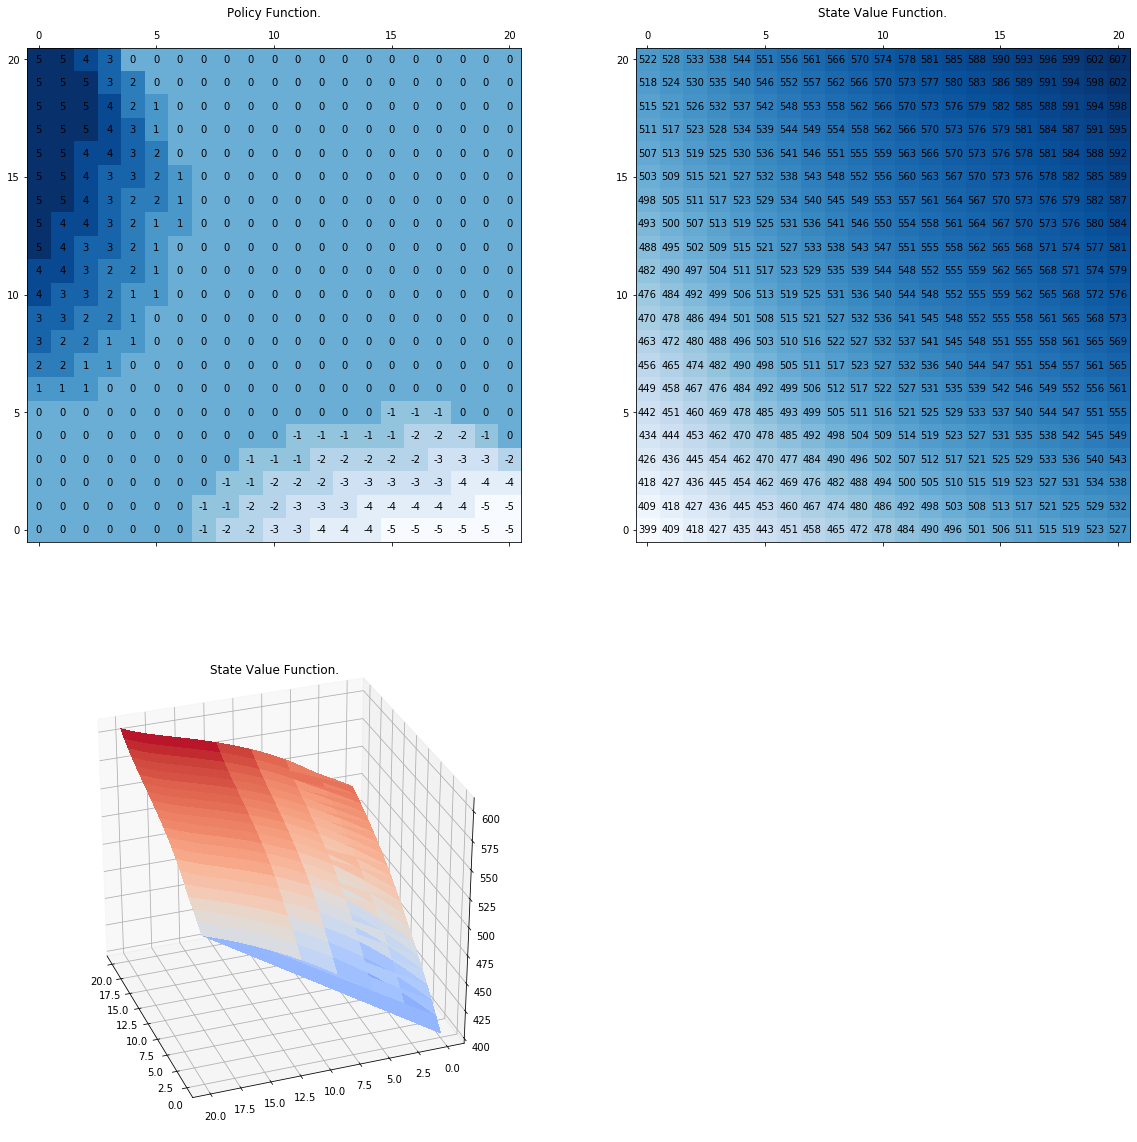

In [260]:
def dict_to_matrix(d):
    """Convert a {(x, y): z} to a matrix with entry [z] in entry x, y.
    """
    matrix = np.zeros((21, 21))
    for i in range(21):
        for j in range(21):
            matrix[i, j] = d[(i, j)]
    return matrix

def annotated_matrix(ax, matrix):
    """Plot annotated matrix in axis.
    """
    ax.matshow(matrix, cmap=plt.cm.Blues)
    plt.gca().invert_yaxis()
    for i in range(21):
        for j in range(21):
            c = matrix[j, i]
            ax.text(i, j, str(int(c)), va='center', ha='center')

def plot_surface(ax, d):
    """Plot a surface of {(x,y): z}
    """
    # Make data.
    X = np.array([s[0] for s in d.keys()])
    Y = np.array([s[1] for s in d.keys()])
    X, Y = np.meshgrid(X, Y)

    @np.vectorize
    def look_up(x, y):
        return d[(x, y)]
    Z = look_up(X, Y)
    
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.view_init(30, 160)

# Make the plots.            
            
fig = plt.figure(figsize=(20, 20))

ax1 = plt.subplot(221)
annotated_matrix(
    ax1,
    dict_to_matrix(policy)
)
_ = ax1.set_title('Policy Function.')


ax2 = plt.subplot(222)
annotated_matrix(
    ax2,
    dict_to_matrix(state_value)
)
_ = ax2.set_title('State Value Function.')


ax3 = fig.add_subplot(223, projection='3d')
plot_surface(
    ax3,
    state_value
)
_ = ax3.set_title('State Value Function.')

# Profiling

In [ ]:
import cProfile

def profile():
    state_value = {s: 0 for s in STATES}
    policy = {s: 0 for s in STATES}
    for state_progress, state in enumerate(STATES):
            action = policy[state]
            state_value[state] = action_value(state, 0, state_value)

cProfile.run('profile()')

# Exercise 4.5 (programming)
Write a program for policy iteration and re-solve Jack’s car rental problem with the following changes. One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs \\$2, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of $4 must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem. If your computer is too slow for the full problem, cut all the numbers of cars in half.